In [1]:
import json
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import subprocess
import itertools
import os.path
from collections import defaultdict

## Reference cross sections

In [2]:
with open("../tables/Lambda.compt.gamma.json") as f:
    ref = json.load(f)['physics_vector']
ref_e = np.array(ref['energy'])
ref_xs = np.array(ref['xs_eloss'])

# NOTE: lambda prime tables are scaled by E
with open("../tables/LambdaPrim.compt.gamma.json") as f:
    ref = json.load(f)['physics_vector']
prime_e = np.array(ref['energy'])[1:]
prime_xs = np.array(ref['xs_eloss'])[1:] / prime_e

ref_e = np.concatenate([ref_e, prime_e])
ref_xs = np.concatenate([ref_xs, prime_xs])

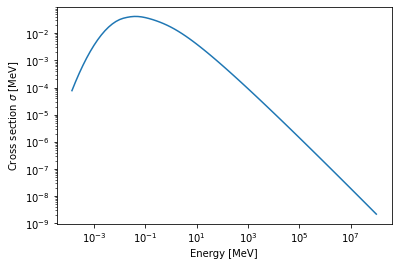

In [3]:
(fig, ax) = plt.subplots(1, 1, subplot_kw=dict(xscale='log', yscale='log'))
ax.plot(ref_e, ref_xs)
ax.set_xlabel('Energy [MeV]')
ax.set_ylabel(r'Cross section $\sigma$ [MeV]');
fig.savefig(f"xs.pdf")

In [4]:
initial_energy = 100.0 # MeV

In [5]:
invmm_to_invcm = 10
xs_value = ref_xs[np.where(ref_e == initial_energy)][0] * invmm_to_invcm
xs_value

0.006512407533599999

## Run interactively

In [8]:
run_args =  {
    'seed': 12345,
    'energy': initial_energy,
    'max_steps': 128,
    'tally_grid': {
        'size': 2048,
        'front': 0,
        'delta': 1,
    }
}

def run(block_size, grid_size, tracks_per_thread=1):
    inp = {
        'grid_params': {
            'block_size': block_size,
            'grid_size': grid_size,
        },
        'run': run_args.copy()
    }
    inp['run']['num_tracks'] = block_size * grid_size * tracks_per_thread
    
    results = subprocess.check_output([
        "ssh", "wildstyle", "~/.local/src/celeritas/build-opt/app/demo-interactor", "-"],
        input=json.dumps(inp).encode())
    return json.loads(results.decode())


In [9]:
results = run(256, 256*128, 2)
print("Completed", results['run']['num_tracks'], "tracks in", results['result']['total_time'], "seconds")

Completed 16777216 tracks in 2.422256033 seconds


In [10]:
tally = results['run']['tally_grid']
grid = np.arange(tally['size'] + 1) * tally['delta'] + tally['front']

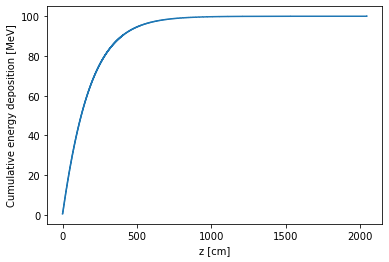

In [11]:
edep = np.array(results['result']['edep'])
(fig, ax) = plt.subplots()
ax.plot(grid[:-1], np.cumsum(edep), drawstyle='steps-post')
#ax.plot(grid, (1 - np.exp(-xs_value * grid)), color='r')
ax.set_xlabel('z [cm]')
ax.set_ylabel('Cumulative energy deposition [MeV]');
fig.savefig(f"edep-accum-{initial_energy:.0f}MeV.png", dpi=300)

In [12]:
# Export to numpy
np.savetxt(f"edep-{initial_energy:.0f}MeV-{tally['delta']}cm.txt", edep)

In [ ]:
edep_per_dist = edep / tally['delta']
alive = np.array(results['result']['alive'])
time = np.array(results['result']['time'])

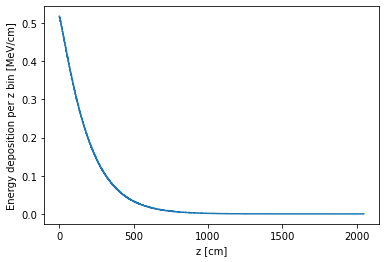

In [13]:
(fig, ax) = plt.subplots()
ax.plot(grid[:-1], edep_per_dist, drawstyle='steps-post')
ax.set_xlabel('z [cm]')
ax.set_ylabel('Energy deposition per z bin [MeV/cm]');
fig.savefig(f"edep-{initial_energy:.0f}MeV.png", dpi=300)

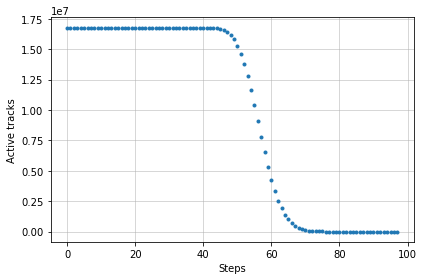

In [53]:
(fig, ax) = plt.subplots()
ax.plot(alive[:-1], '.')
ax.set_xlabel('Steps')
ax.set_ylabel('Active tracks')
ax.grid(linewidth=.5)
ax.set_axisbelow(True)
fig.tight_layout()
fig.savefig('active-tracks.pdf')

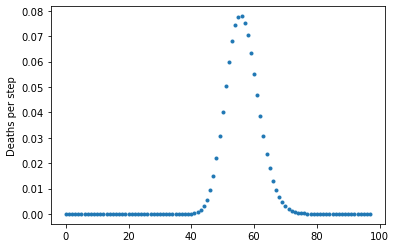

In [15]:
plt.plot(np.diff(-alive/alive[0]), '.')
plt.ylabel('Deaths per step');

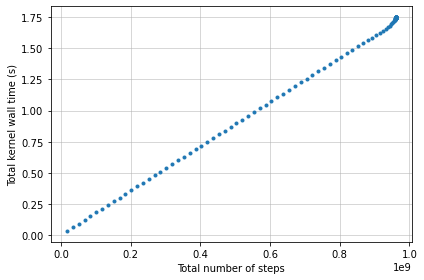

In [52]:
# Time per track
(fig, ax) = plt.subplots(1, 1)
ax.plot(np.cumsum(alive[:-1]), np.cumsum(time), '.')
ax.set_xlabel('Total number of steps')
ax.set_ylabel('Total kernel wall time (s)')
ax.grid(linewidth=.5)
ax.set_axisbelow(True)
fig.tight_layout()
fig.savefig('total-time.pdf')

In [55]:
tfrac = np.cumsum(time)
tfrac /= tfrac[-1]

In [59]:
steps = np.cumsum(alive[:-1])

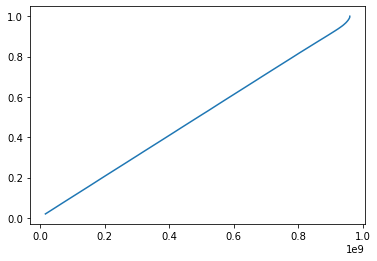

In [69]:
plt.plot(steps, tfrac, '.')

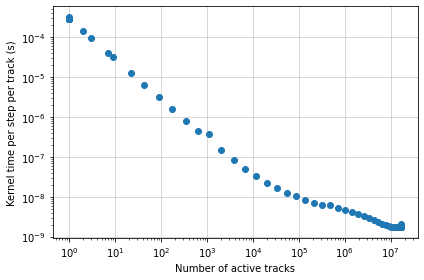

In [50]:
# Time per track
(fig, ax) = plt.subplots(1, 1, subplot_kw=dict(xscale='log', yscale='log'))
ax.scatter(alive[:-1], time / alive[:-1])
ax.set_xlabel('Number of active tracks')
ax.set_ylabel('Kernel time per step per track (s)');
ax.grid(linewidth=.5)
ax.set_axisbelow(True)
fig.tight_layout()
fig.savefig('time-per-step.pdf')

## Time scaling

In [18]:
def run_one_scaling(scaling_results, *args):
    try:
        result = run(*args)
    except subprocess.CalledProcessError:
        print("FAILED to run:", args)
        return

    scaling_results['steps'].append(sum(result['result']['alive']))
    scaling_results['kernel_time'].append(sum(result['result']['time']))
    scaling_results['total_time'].append(result['result']['total_time'])
    scaling_results['block_size'].append(result['grid_params']['block_size'])
    scaling_results['grid_size'].append(result['grid_params']['grid_size'])
    scaling_results['tracks'].append(result['run']['num_tracks'])

In [33]:
if os.path.exists('scaling.json'):
    with open('scaling.json') as f:
        scaling_results = json.load(f)
else:
    scaling_results = defaultdict(list)

    # Note: block size of 1024 always fails due to insufficient registers
    for (bs, gs, tpt) in itertools.product(
            [128, 256, 512],
            [64, 128, 256, 512, 1024, 2048, 4096],
            [1, 2, 4, 8, 16]):
        run_one_scaling(scaling_results, bs, gs, tpt)
        
        
    with open('scaling.json', 'w') as f:
        json.dump({k: v.tolist() for k, v in scaling_results.items()}, f, indent=1)

In [35]:
scaling_results = {k: np.array(v) for k, v in scaling_results.items()}

In [36]:
from matplotlib.colors import LogNorm

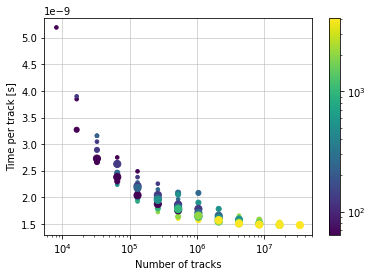

In [86]:
(fig, ax) = plt.subplots(1, 1, subplot_kw=dict(xscale='log', yscale='linear'))
time_per_step = scaling_results['kernel_time'] / scaling_results['steps']
time_per_track = scaling_results['kernel_time'] / scaling_results['tracks']
num_threads = scaling_results['block_size'] * scaling_results['grid_size']
tracks_per_thread = scaling_results['tracks'] // num_threads
single_thread = (tracks_per_thread == 1)
scat = ax.scatter(scaling_results['tracks'], time_per_step,
          c=scaling_results['grid_size'], norm=LogNorm(),
          s=scaling_results['block_size'] / 10)
fig.colorbar(scat)
ax.grid(linewidth=.5)
ax.set_axisbelow(True)
ax.set_xlabel('Number of tracks')
ax.set_ylabel('Time per track [s]');

In [38]:
import pandas as pd

In [39]:
df = pd.DataFrame(scaling_results)
df.index = pd.MultiIndex.from_arrays([df['tracks'],df['block_size'], df['grid_size']])
df.sort_index(inplace=True)

In [89]:
time_per_track = df['kernel_time'] / df['tracks']

In [43]:
time_per_track.xs(2**20, level='tracks')

block_size  grid_size
128         512          9.536864e-08
            1024         9.755360e-08
            2048         9.431426e-08
            4096         8.964787e-08
256         256          1.192995e-07
            512          1.088941e-07
            1024         9.550286e-08
            2048         9.256439e-08
            4096         9.005709e-08
512         128          1.021118e-07
            256          9.796298e-08
            512          9.421594e-08
            1024         9.382028e-08
            2048         9.492576e-08
dtype: float64

In [96]:
gpu_tpt = time_per_track.xs(256, level='block_size').unstack(level='grid_size')

## CPU comparison

In [2]:
def run_cpu(num_tracks):
    inp = {
        'run': run_args.copy()
    }
    inp['run']['num_tracks'] = num_tracks
    
    results = subprocess.check_output([
        "ssh", "wildstyle", "~/.local/src/celeritas/build-opt/app/host-demo-interactor", "-"],
        input=json.dumps(inp).encode())
    return json.loads(results.decode())

In [3]:
def run_one_scaling_cpu(scaling_results, *args):
    try:
        result = run_cpu(*args)
    except subprocess.CalledProcessError:
        print("FAILED to run:", args)
        return

    scaling_results['steps'].append(sum(result['result']['alive']))
    scaling_results['kernel_time'].append(sum(result['result']['time']))
    scaling_results['total_time'].append(result['result']['total_time'])
    scaling_results['tracks'].append(result['run']['num_tracks'])

In [4]:
if os.path.exists('scaling-gpu-short.json'):
    with open('scaling-gpu-short.json') as f:
        gpu_scaling_results_short = json.load(f)
else:
    gpu_scaling_results_short = defaultdict(list)
    for log_gs in range(4, 20):
        run_one_scaling(gpu_scaling_results_short, 256, 2**log_gs, 1)
        
    with open('scaling-gpu-short.json', 'w') as f:
        json.dump(gpu_scaling_results_short, f, indent=1)
        
gpu_scaling_results_short = {k: np.array(v) for k, v in gpu_scaling_results_short.items()}

In [5]:
if os.path.exists('scaling-cpu.json'):
    with open('scaling-cpu.json') as f:
        cpu_scaling_results = json.load(f)
else:
    cpu_scaling_results = defaultdict(list)
    for num_tracks in gpu_scaling_results_short['tracks'][:-1].tolist():
        print(f'Running {num_tracks}...')
        run_one_scaling_cpu(cpu_scaling_results, num_tracks)
        print(f'...total time: {cpu_scaling_results["total_time"][-1]}')
        
    with open('scaling-cpu.json', 'w') as f:
        json.dump(cpu_scaling_results, f, indent=1)
        
cpu_scaling_results = {k: np.array(v) for k, v in cpu_scaling_results.items()}

In [6]:
cpu_scaling_results

{'steps': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'kernel_time': array([8.87922100e-02, 1.79278092e-01, 3.58154578e-01, 7.20491962e-01,
        1.43940200e+00, 2.89260939e+00, 5.78880408e+00, 1.14754305e+01,
        2.29246980e+01, 4.58074975e+01, 9.18979010e+01, 1.83516425e+02,
        3.66381703e+02, 7.35486267e+02]),
 'total_time': array([8.97452270e-02, 1.81180309e-01, 3.62219036e-01, 7.28105984e-01,
        1.45434847e+00, 2.93066515e+00, 5.84980074e+00, 1.15981384e+01,
        2.31702274e+01, 4.63001665e+01, 9.28722208e+01, 1.85475425e+02,
        3.70301536e+02, 7.43286587e+02]),
 'tracks': array([    4096,     8192,    16384,    32768,    65536,   131072,
          262144,   524288,  1048576,  2097152,  4194304,  8388608,
        16777216, 33554432])}

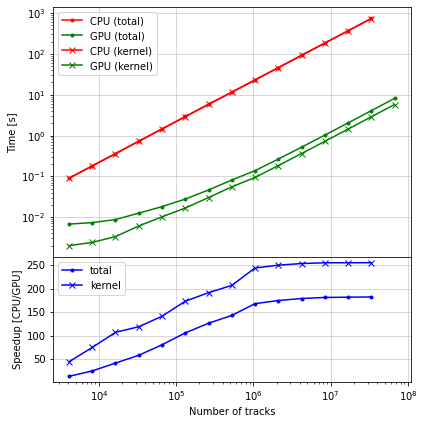

In [8]:
_c = cpu_scaling_results
_g = gpu_scaling_results_short
rel_slc = slice(min(len(data['tracks']) for data in [_c, _g]))

(fig, [ax, rel_ax]) = plt.subplots(
    2, 1,
    subplot_kw=dict(xscale='log'),
    gridspec_kw=dict(hspace=0, height_ratios=[2., 1.]),
    figsize=(6,6),
    sharex=True)
for t_label, marker in [('total', '.'), ('kernel', 'x')]:
    for hd_label, color, data in [('CPU', 'r', _c), ('GPU', 'g', _g)]:
        ax.plot(data['tracks'], data[t_label + '_time'],
                label=f'{hd_label} ({t_label})', color=color, marker=marker)
    speedup = _c[t_label + '_time'][rel_slc] / _g[t_label + '_time'][rel_slc]
    rel_ax.plot(data['tracks'][rel_slc], speedup,
                label=t_label, color='b', marker=marker)

ax.set_yscale('log')
ax.grid(linewidth=.5)
ax.legend()
ax.set_axisbelow(True)
ax.set_ylabel('Time [s]')
rel_ax.legend()
rel_ax.grid(linewidth=.5)
rel_ax.set_ylabel('Speedup [CPU/GPU]')
rel_ax.set_xlabel('Number of tracks');
fig.tight_layout()
fig.savefig('cpu-gpu-comparison.pdf')

## 1 MeV distributions

From the unit test.

In [28]:
nsamples = 10000
eps = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 182, 285, 235, 208, 220, 208, 183, 165, 177, 147, 135, 154, 139, 148, 150, 137, 134, 124, 132, 112, 126, 112, 122, 105, 124, 99, 98, 105, 110, 124, 109, 110, 108, 109, 111, 109, 102, 111, 94, 104, 126, 88, 107, 103, 97, 104, 116, 122, 107, 107, 114, 109, 98, 103, 110, 106, 104, 105, 109, 108, 102, 100, 115, 110, 118, 116, 117, 101, 121, 123, 100, 118, 118, 118, 107, 133, 120, 127, 113, 113])
costheta = np.array([49, 51, 40, 45, 49, 52, 52, 45, 54, 58, 52, 39, 38, 45, 60, 46, 49, 47, 34, 49, 38, 52, 58, 62, 59, 53, 50, 35, 44, 61, 58, 47, 50, 48, 59, 57, 50, 56, 54, 49, 50, 39, 56, 57, 68, 49, 64, 56, 59, 67, 75, 55, 77, 69, 76, 66, 60, 76, 80, 67, 74, 68, 79, 75, 77, 90, 80, 82, 96, 82, 82, 85, 94, 126, 117, 105, 111, 119, 136, 126, 137, 117, 157, 169, 144, 163, 167, 214, 203, 222, 202, 233, 257, 262, 289, 320, 353, 365, 412, 450])

In [29]:
grid = np.linspace(0, 1, len(eps) + 1)

Text(0.5, 0, '$E_{\\mathrm{out}} / E_{\\mathrm{in}}$')

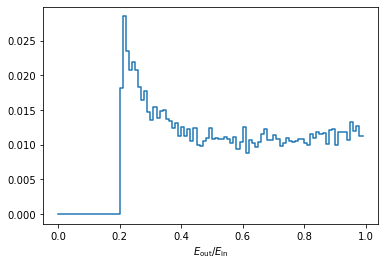

In [30]:
plt.plot(grid[:-1], eps / nsamples, drawstyle="steps-post")
plt.xlabel(r"$E_{\mathrm{out}} / E_{\mathrm{in}}$")

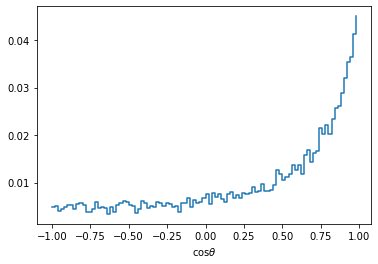

In [31]:
plt.plot((grid * 2 - 1)[:-1], costheta / nsamples, drawstyle="steps-post")
plt.xlabel(r"$\cos \theta$");